In [0]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
%matplotlib inline

# Домашнее задание 1

ДЕДЛАЙН: 7 марта, 23:59

В этой работе мы проведём ещё одно экспериментальное исследование методов интерполяции.

## Кубические сплайны

Сплайны -- один из самых используемых ан практике базисов интерполяции, который отличает устойчивость к шумам и простота вычислений. Пусть $In_A( x)=1$, если $x \in A$, и $0$ иначе. В общем случае сплайном степени $n$ дефекта $k$ называют кусочно заданную функцию 
$$
S(x) = \sum_{j=0}^K S_j(x) In(x \in I_j),
$$
определённую для $x \in [a,b]$, где $S_j$ являются многочленами степени $n$, объеденение отрезков $I_j$, среди которых пересекаются только соседние и в одной точке, равно $[a,b]$ и выполнены условия 

1. Непрерывности $S(x)$ на стыках интервалов: если $I_j=[t_0,t_1],~I_{j+1}=[t_1,t_2]$, то $S_j(t_1)=S_{j+1}(t_1);$
2. Непрерывности производной на стыках интервалов: для всех натуральных $k_0 \leq n-k ~~~ S_j^{(k_0)}(t_1)=S_{j+1}^{(k_0)}(t_1).$


Нам требуется найти сплайн, интерполирующий функцию $f(x)$ между узлами интерполяции $t_j$ на отрезке $[a,b]$; из определения очевидно, что вопрос существования интерполирующего сплайна с заданными степенью и дефектом не такой очевидный. В этом курсе мы рассматриваем для простоты кубический сплайн дефекта 1, который используется на практике чаще всех остальных и единственен для любого набора узлов интерполяции. Для построения такого сплайна существует простая процедура(см. лекции), основанная на методе прогонке и имеющая сложность $O(N)$. Для единственности сплайна необходимо задать граничные условия, используйте $S''(b)=S''(a)=0$, но в коде предполагайте, что пользователь сам задаёт $S''(a)$ и $S''(b)$ в качестве входных параметров.

### Задание 1 (50 баллов)

Реализуйте процедуру для интерполяции кубическим сплайном, взяв за основу код, приведённый ниже.

In [0]:
class CubicSplineInterpolator:
    
    def __init__(self,xGrid,fGrid, ddSa = 0., ddSb = 0.):
        #Computes spline coefficients
        #print('xs', xGrid)
        #print('ys', fGrid)
        self.xs = xGrid
        self.ys = fGrid
        self.n = len(self.xs) - 1
        self.ddSa = ddSa
        self.ddSb = ddSb
        
        #self.xGrid = xGrid #you will need it
        self.coeffs = self.ComputeCoefficients(xGrid,fGrid)
        #I would recommended to use list(or numpy array [N-1,3]) for coefficients
        
    def ComputeCoefficients(self,xs,ys):
        #returns coefficients for cubic spline based on interpolation Grid
        #input
        #    xGrid float64 [N]
        #    fGrid float64 [N]
        #output
        #    coeffs
        n = len(xs) - 1
        h = xs[1:] - xs[:-1]
        assert(np.all(h >= 0))
        #print(h)
        a = h[:-1] / (h[:-1] + h[1:])
        b = np.ones(n - 1) - a
        a = np.append(a, [0,])
        b = np.append([0,], b)
        #print(a)
        #print(b)
        g = ys[1:] - ys[:-1]
        gh = g / h
        d = (g[1:] - g[:-1]) / (h[:-1] + h[1:])
        d = np.concatenate(([2*self.ddSa,], 6*d, [2*self.ddSb,]))
        #print('d', d)
        #mat = scipy.sparse.diags((a, 2*np.ones(n+1), b), offsets=(-1, 0, 1)).toarray()
        #print(mat)
        #print('exp', np.linalg.solve(mat, d))
        m = self._solve(a, 2*np.ones(n+1), b, d)
        #print('got', np.matmul(mat, m))
        self._postproc(m, h, ys)
        self._compute = np.vectorize(lambda x: self._s(x))
        return self.c

    def _solve(self, a, b, c, d):
        n = len(d)
        p = [-c[0] / b[0],]
        q = [d[0] / b[0],]
        for i in range(1, n - 1):
          p.append(c[i] / (-a[i-1]*p[i-1] -b[i]))
          q.append((-d[i] + a[i-1] * q[i-1]) / (-a[i-1]*p[i-1] - b[i]))
        #print('p', p)
        #print('q', q)
        x = [(d[n-1] - q[n-2]*a[n-2]) / (b[n-1] + p[n-2]*a[n-2]),]
        #print(n-1, x[0])
        for i in range(n - 2, -1, -1):
          x.append(p[i]*x[-1] + q[i])
          #print(i, x[-1])
        #print(x)
        return np.flip(x)

    def _postproc(self, m, h, y):
        c0 = m[:-1] / (6*h) # (x_i - x)^3
        c1 = m[1:] / (6*h)  # (x - x_{i-1})^3
        c2 = (y[:-1] - (m[:-1]*h*h)/6)/h  # (x_i - x)
        c3 = (y[1:] - (m[1:]*h*h)/6)/h    # (x - x_{i-i})
        self.c = np.array([c0, c1, c2, c3])
        #print(self.c)

    def _ci(self, x, i):
        return self.c[0][i]*(self.xs[i+1] - x)**3 + \
               self.c[1][i]*(x - self.xs[i])**3 + \
               self.c[2][i]*(self.xs[i+1] - x) + \
               self.c[3][i]*(x - self.xs[i])

    def _s(self, x):
        if x < self.xs[0] or self.xs[-1] < x:
          raise Exception('undefined')
        i = 0
        while self.xs[i+1] < x:
          i+=1 
        return self._ci(x, i)

    def Compute(self,x):
        #computes spline value at point x
        #input
        #    x float64 [batch]
        #output
        #    S(x) float64 [batch]
        return self._compute(x)

Проверьте, как работает интерполяция для функции $f(x)$ без шума и в случае $\tilde{f}(x) = f(x) + \sigma \mathcal{N}(0,1)$. Нарисуйте графики $S(x),f(x)$ и узлы интерполяции (используйте scatter). Попробуйте несколько разных $\sigma$.

Сравните результат с интерполяцией многочленами Ньютона и тригонометрической интерполяцией (см. семинары).

In [0]:
def fTest(x):
    #maps R -> R
    #input x [batch]
    #output [batch]
    
    return np.exp(-0.1*x) + 1/x * np.sin(1*np.pi * x)+ np.exp(0.07*x)

def mkplot(number_of_knots=100, sigma=0.0, method=CubicSplineInterpolator):
  x0=1
  x1=15
  N= 10000
  h= (x1-x0)/(N-1)
  xs = np.arange(x0,x1+h/2,h)
  ys = fTest(xs)

  Nk= number_of_knots
  hk= (x1-x0)/(Nk-1)
  xsk = np.arange(x0,x1+hk/2,hk)
  ysk = fTest(xsk)

  noise = sigma * np.random.normal(size=Nk)
  yskn = ysk + noise

  interp = method(xsk, yskn)

  f,ax = plt.subplots(figsize=(10,10))

  ax.grid()
  ax.set_title(type(interp).__name__ + ', N = ' + str(Nk) + ', sigma = ' + str(sigma))
  ax.set_xlabel('x')
  ax.plot(xs,ys, label='f(x)')
  ax.plot(xs, interp.Compute(xs), label='S(x)')
  ax.scatter(xsk, ysk, label='knots')
  ax.scatter(xsk, yskn, marker='x', label='noised knots')
  ax.legend()
  #print(xs)
  #print(fTest(xs))
  #print(xs[:-1])

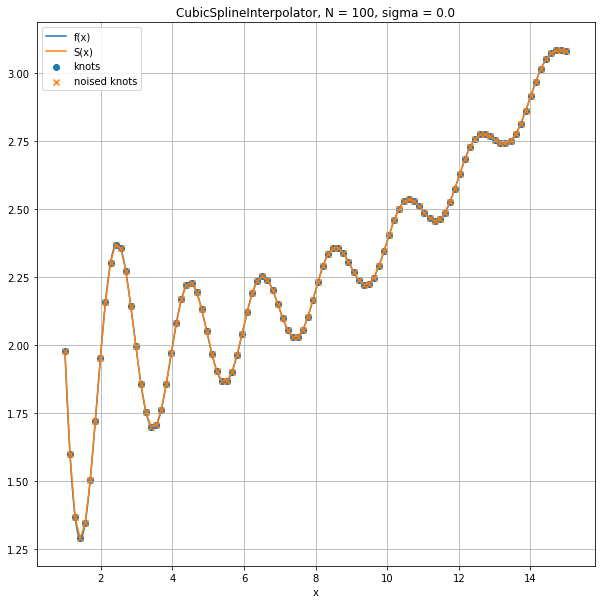

In [240]:
mkplot()

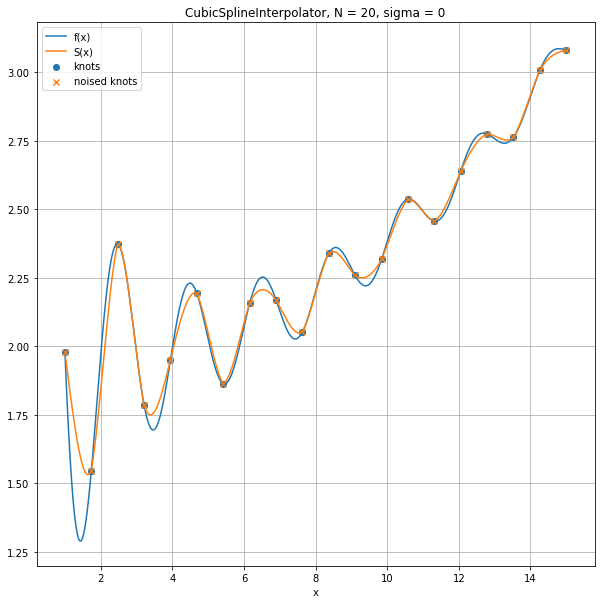

In [260]:
mkplot(20, 0) 

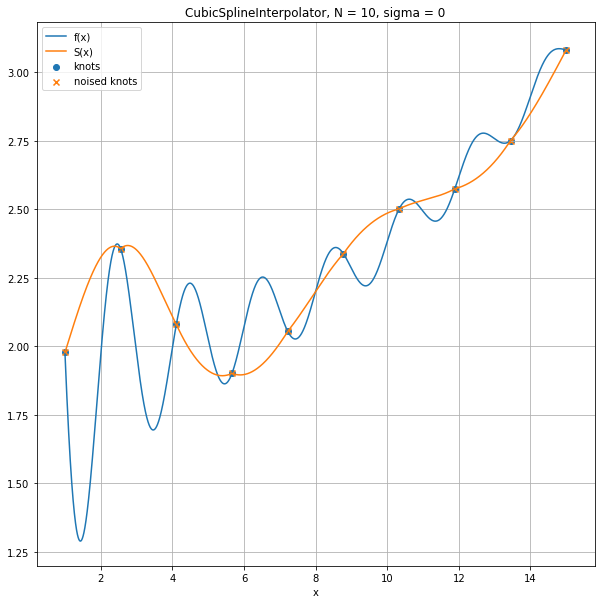

In [261]:
mkplot(10, 0) 

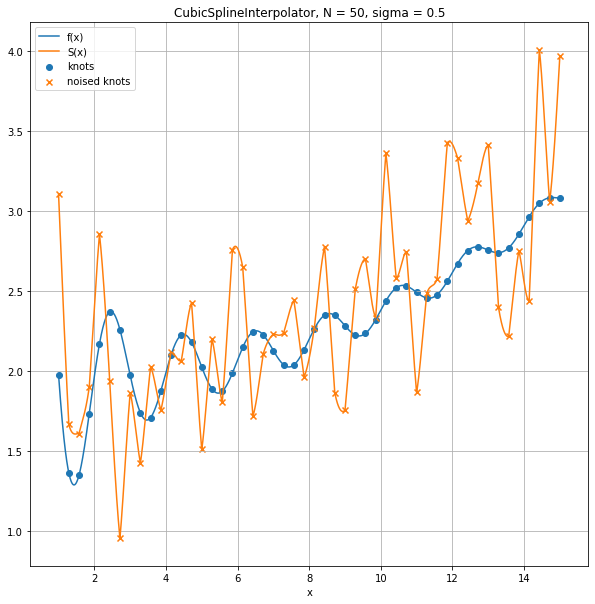

In [262]:
mkplot(50, 0.5)

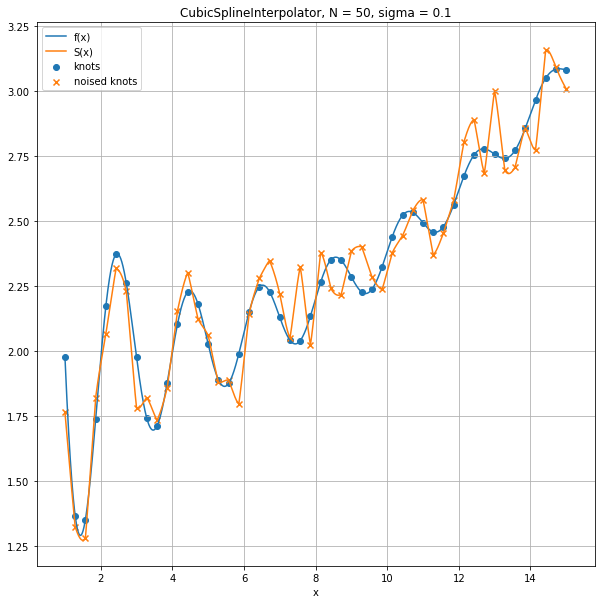

In [263]:
mkplot(50, 0.1)

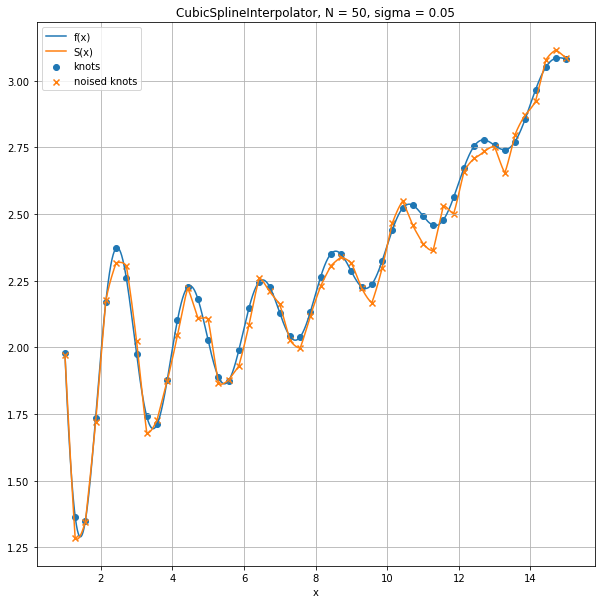

In [264]:
mkplot(50, 0.05)

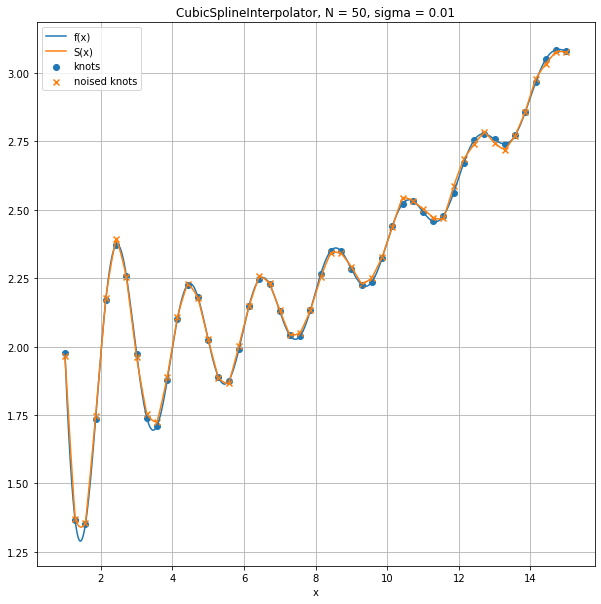

In [265]:
mkplot(50, 0.01)

In [0]:
class Fourier1DFFTInterpolator:
    def __init__(self,xs,fs):
        self.x0 = xs[0]
        self.k = xs[-1] - xs[0]
        fft = np.fft.fft(fs)
        self.coefs = 1/len(fs)*fft
        self.kk = np.arange(len(fs))[None,:]
        

    def Compute(self,x):
        xs = (x - np.ones((len(x),)) * self.x0) / self.k
        fs = np.exp( 2*np.pi*1j*xs[:,None]*self.kk) @self.coefs
        return fs

class NewtonPolyInterpolator:
    def __init__(self,xGrid,fs):
        self.xGrid = xGrid
        self.fs = fs
        self.ComputeCoefs(self.xGrid,self.fs)
    
    def ComputeDifferences(self):
        self.diffs = [self.fs]
        for i in np.arange(1,len(self.fs)):
            diff = np.array([ (self.diffs[-1][k+1]-self.diffs[-1][k])/(self.xGrid[i+k]-self.xGrid[k])\
                          for k in np.arange(len(self.diffs[-1])-1)])
            self.diffs = self.diffs +[diff]
        
    def ComputeCoefs(self,xs,fs):
        self.ComputeDifferences()
        self.coefs = np.array([ self.diffs[k][0] \
                               for k in np.arange(len(self.diffs))])
        
    def Compute(self, x):
        if(x.shape[0]>1):
            vals = np.cumprod( x[:,None] - self.xGrid[None,:], axis=-1)[:,:-1]
        else:
            vals = np.cumprod( x - self.xGrid[None,:], axis=-1)[:,:-1]
        vals = np.concatenate([np.ones([x.shape[0],1]), vals],axis=-1)
        return vals@self.coefs  

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


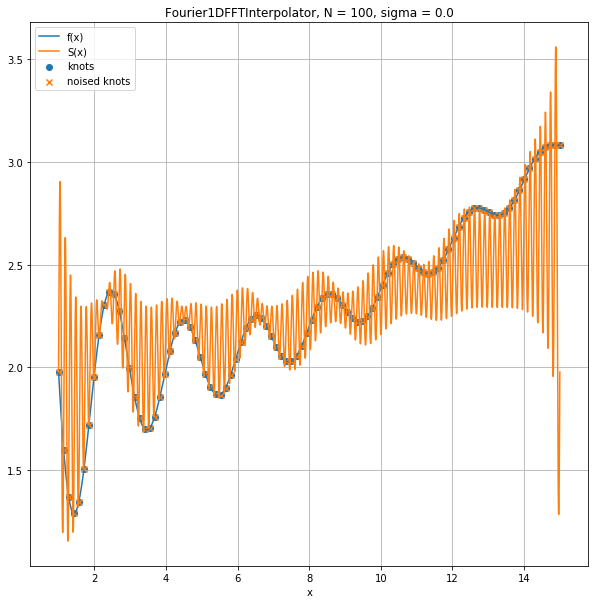

In [246]:
mkplot(method=Fourier1DFFTInterpolator)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


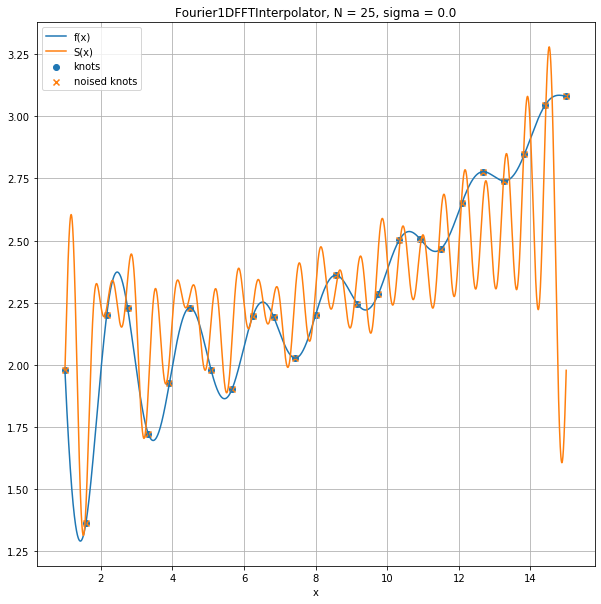

In [247]:
mkplot(25, method=Fourier1DFFTInterpolator)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


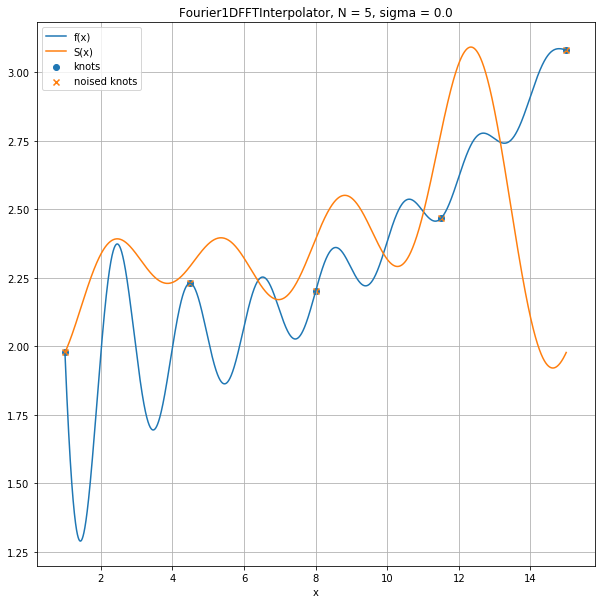

In [248]:
mkplot(5, method=Fourier1DFFTInterpolator)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


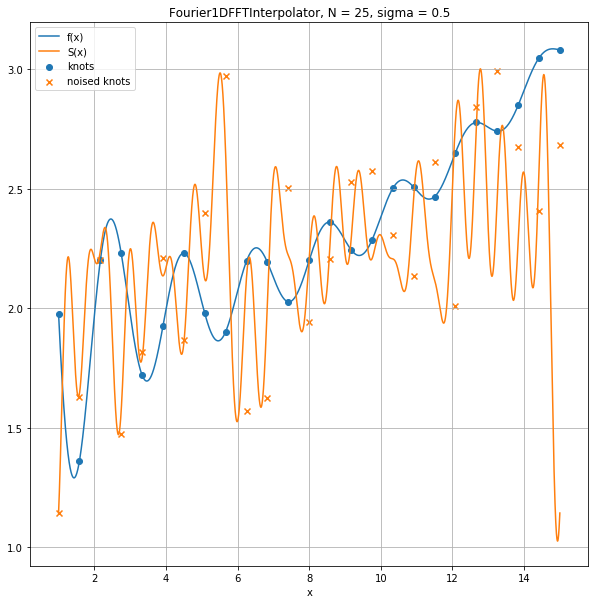

In [249]:
mkplot(25, 0.5, method=Fourier1DFFTInterpolator)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


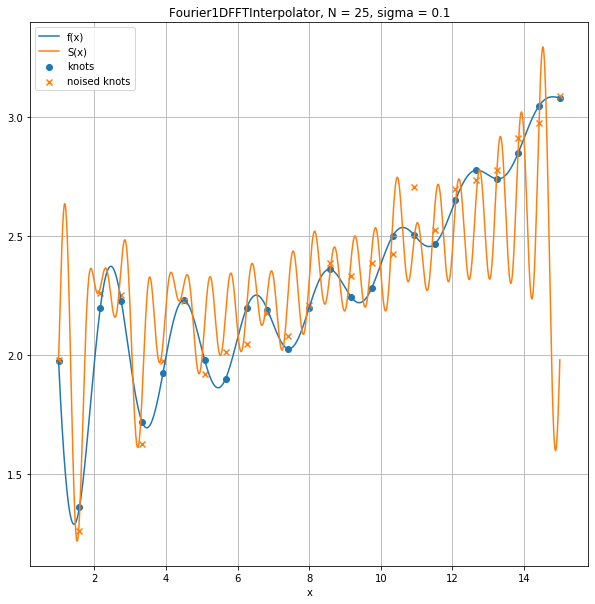

In [250]:
mkplot(25, 0.1, method=Fourier1DFFTInterpolator)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


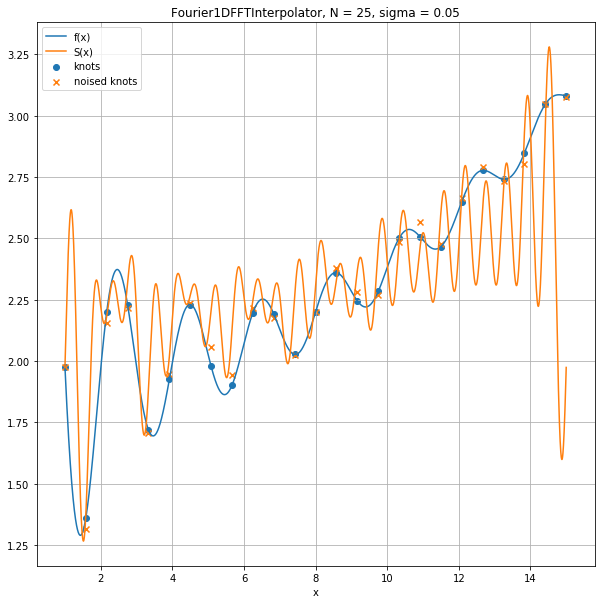

In [251]:
mkplot(25, 0.05, method=Fourier1DFFTInterpolator)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


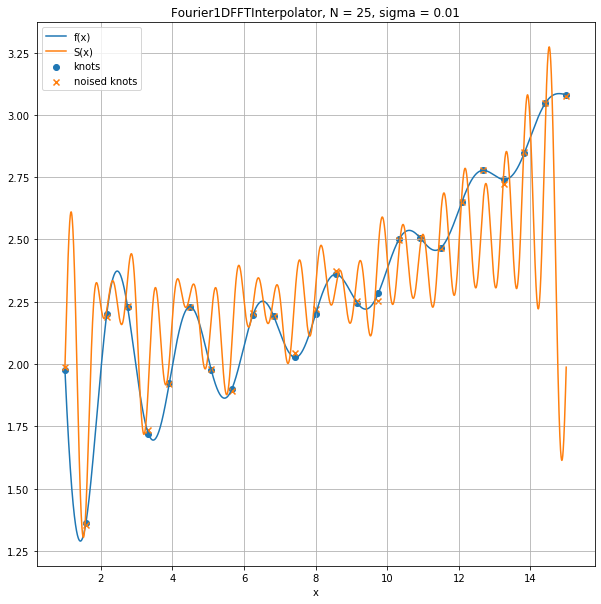

In [252]:
mkplot(25, 0.01, method=Fourier1DFFTInterpolator)

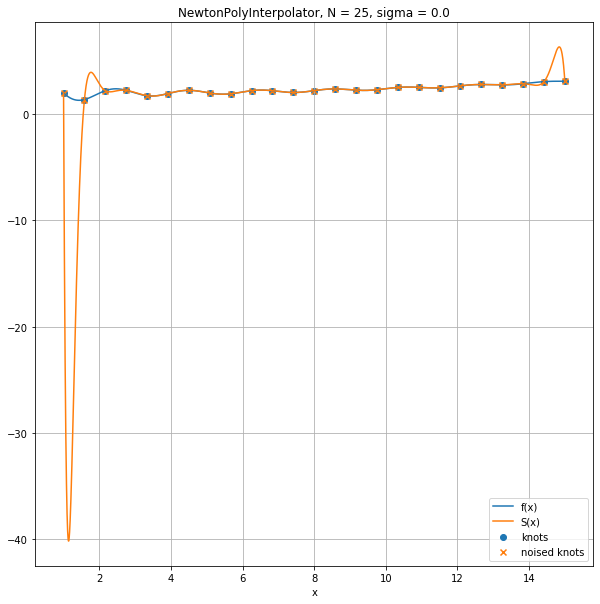

In [253]:
mkplot(25, method=NewtonPolyInterpolator)

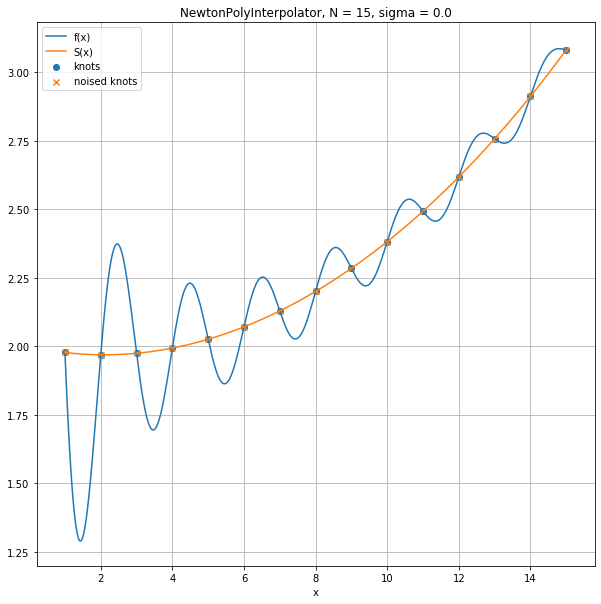

In [254]:
mkplot(15, method=NewtonPolyInterpolator)

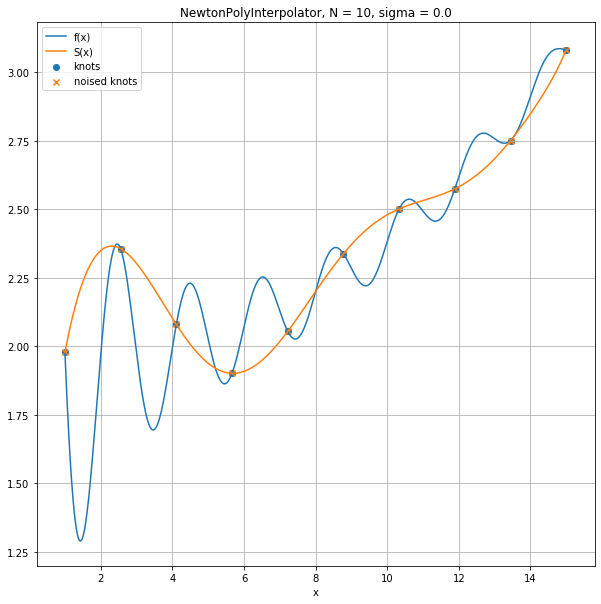

In [255]:
mkplot(10, method=NewtonPolyInterpolator)

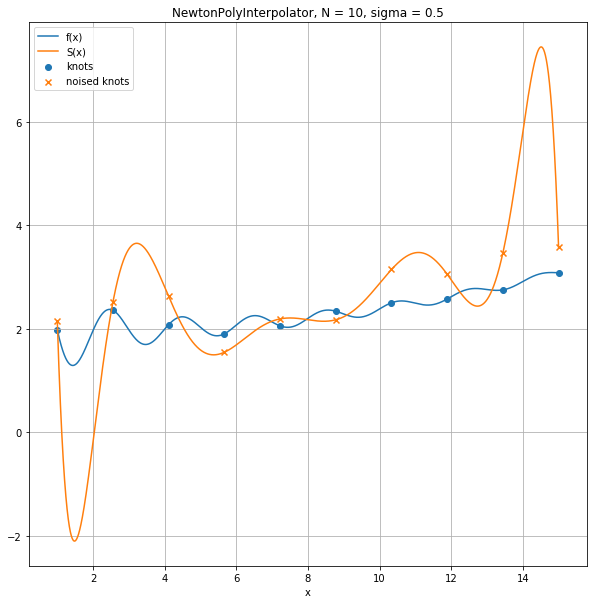

In [256]:
mkplot(10, 0.5, method=NewtonPolyInterpolator)

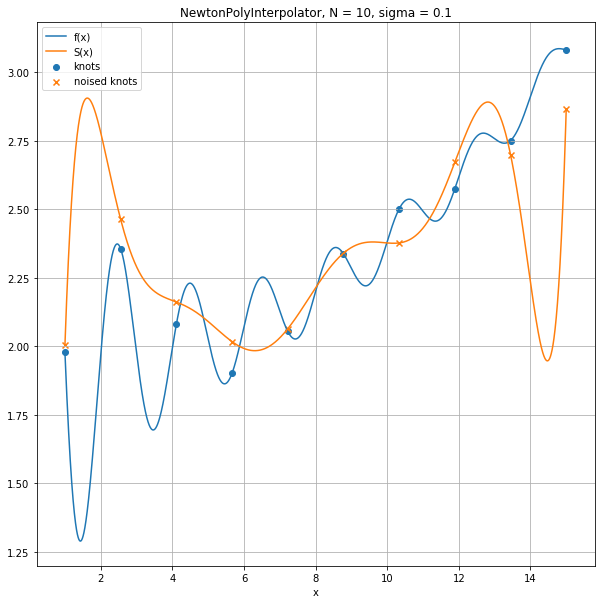

In [257]:
mkplot(10, 0.1, method=NewtonPolyInterpolator)

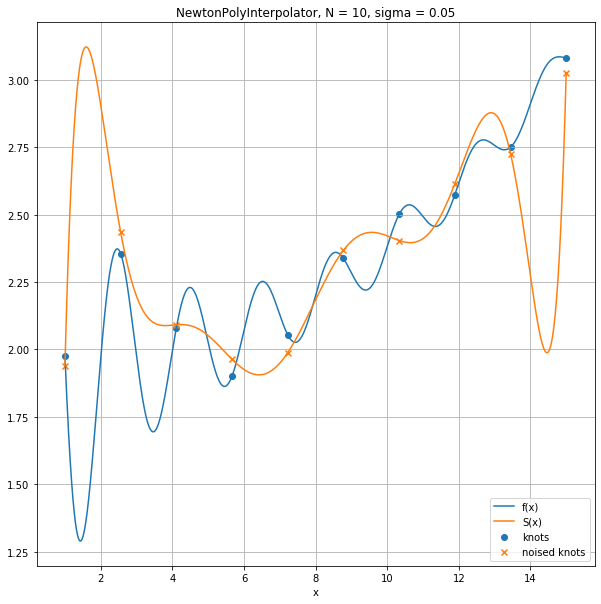

In [258]:
mkplot(10, 0.05, method=NewtonPolyInterpolator)

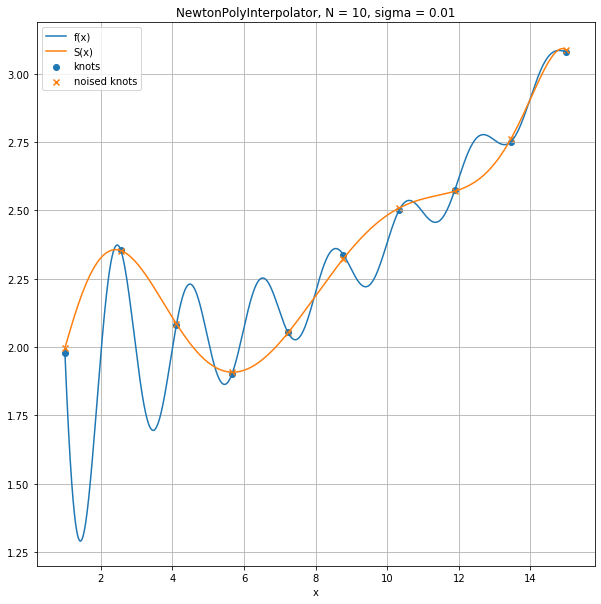

In [259]:
mkplot(10, 0.01, method=NewtonPolyInterpolator)

Нарисуйте график ошибки $S(x)-f(x)$ для интерполяции многочленом Ньютона, тригонометрической интерполяции и интерполяции сплайном для разного числа узлов $N$ в зашумлённом и незашумлённом случае.

In [0]:
def mkerrplot(number_of_knots=10, sigma=0.1, without_newton=False):
  x0=1
  x1=15
  N= 10000
  h= (x1-x0)/(N-1)
  xs = np.arange(x0,x1+h/2,h)
  ys = fTest(xs)

  Nk= number_of_knots
  hk= (x1-x0)/(Nk-1)
  xsk = np.arange(x0,x1+hk/2,hk)
  ysk = fTest(xsk)

  noise = sigma * np.random.normal(size=Nk)
  yskn = ysk + noise

  csi = CubicSplineInterpolator(xsk, yskn)
  fti = Fourier1DFFTInterpolator(xsk, yskn)
  npi = NewtonPolyInterpolator(xsk, yskn)

  f,ax = plt.subplots(figsize=(10,10))

  ax.grid()
  ax.set_title('|f(x) - S(x)|, N = ' + str(Nk) + ', sigma = ' + str(sigma))
  ax.set_xlabel('x')
  ax.plot(xs, np.abs(ys - csi.Compute(xs)), label='Spline')
  ax.plot(xs, np.abs(ys - fti.Compute(xs)), label='Fourier')
  if without_newton == False:
    ax.plot(xs, np.abs(ys - npi.Compute(xs)), label='Newton')
  ax.legend()

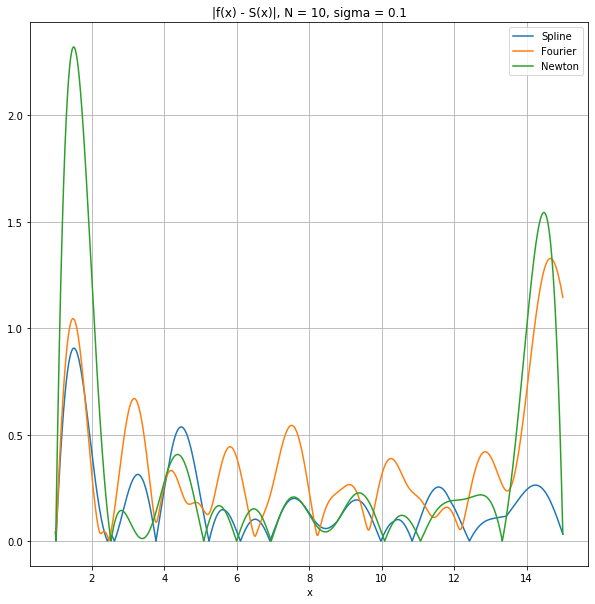

In [283]:
mkerrplot()

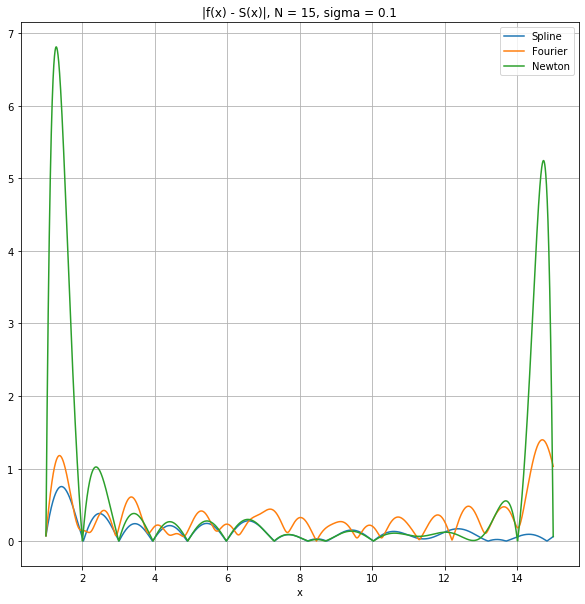

In [271]:
mkerrplot(15)

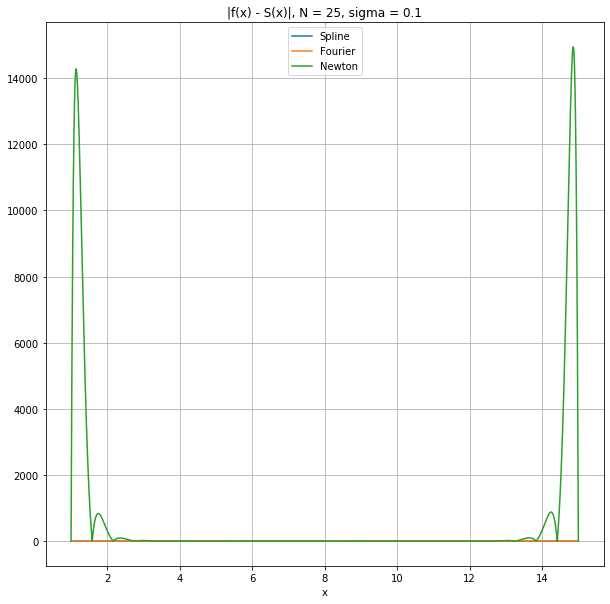

In [272]:
mkerrplot(25)

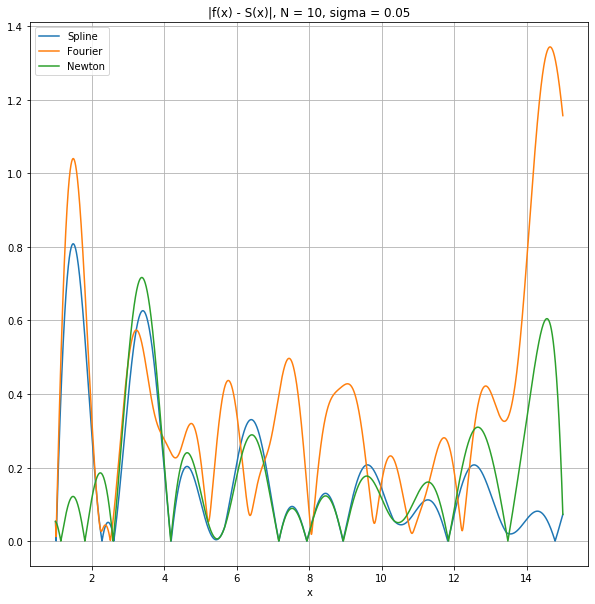

In [275]:
mkerrplot(10, 0.05)

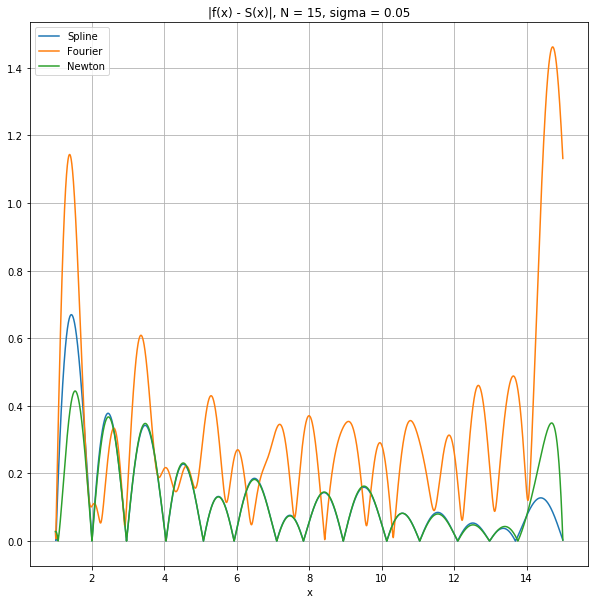

In [276]:
mkerrplot(15, 0.05)

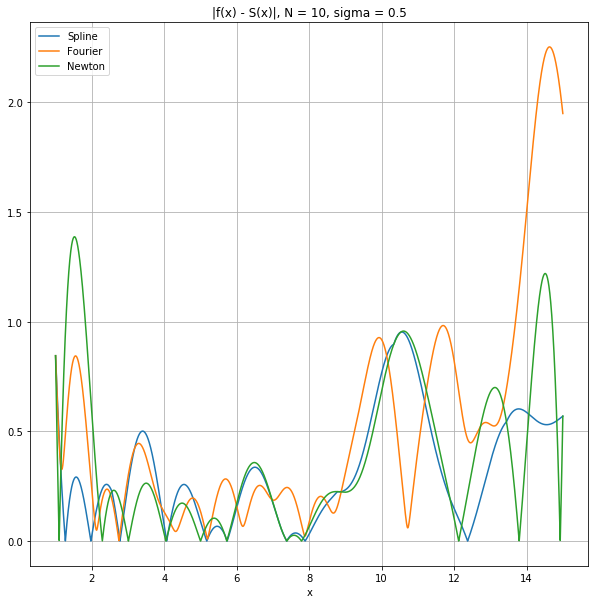

In [277]:
mkerrplot(10, 0.5)

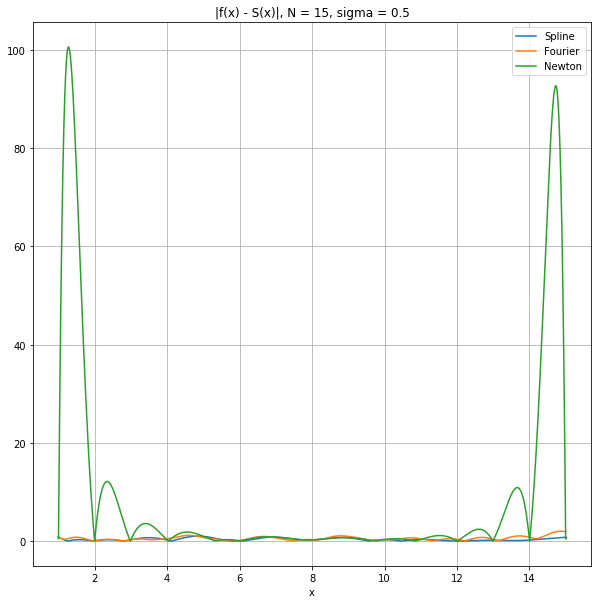

In [17]:
mkerrplot(15, 0.5)

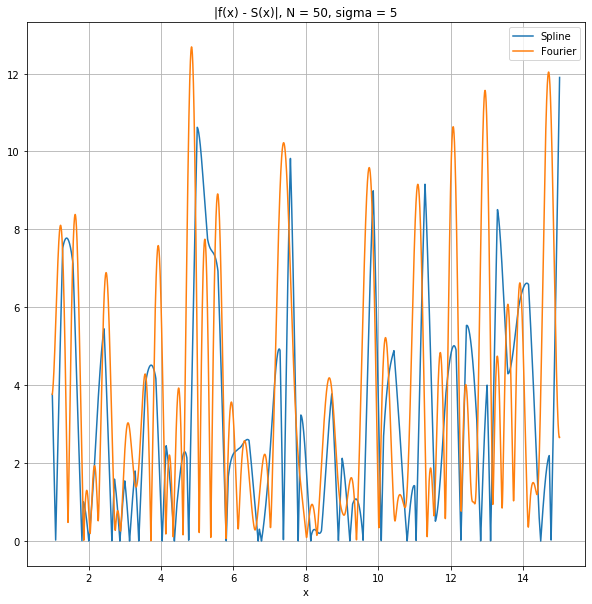

In [20]:
mkerrplot(50, 5, True)

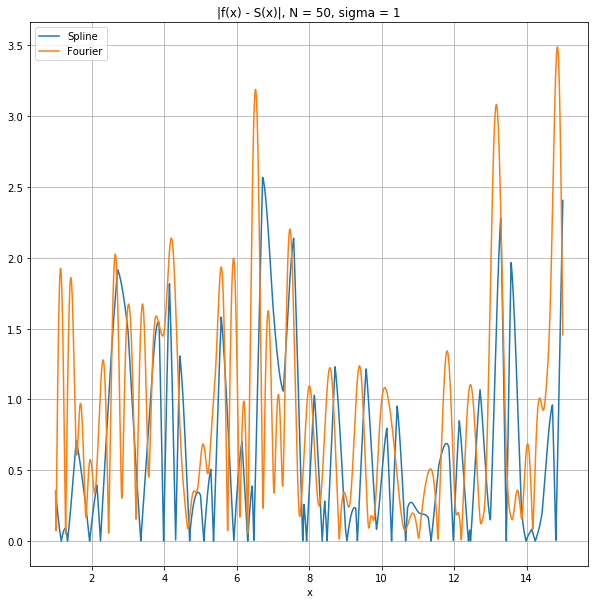

In [285]:
mkerrplot(50, 1, True)

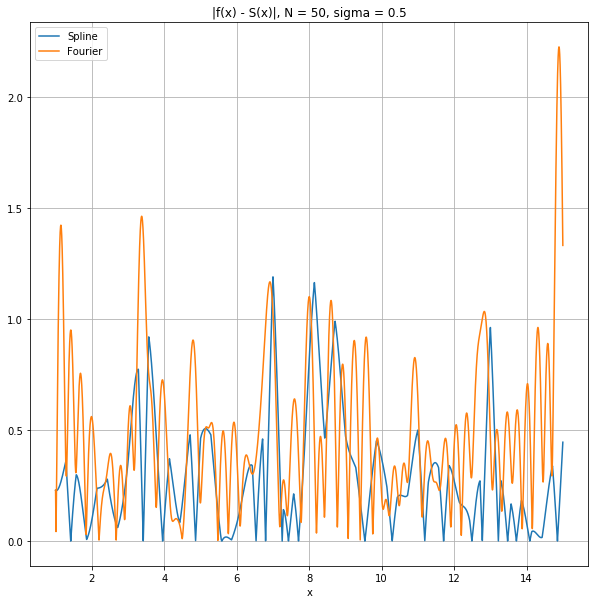

In [286]:
mkerrplot(50, 0.5, True)

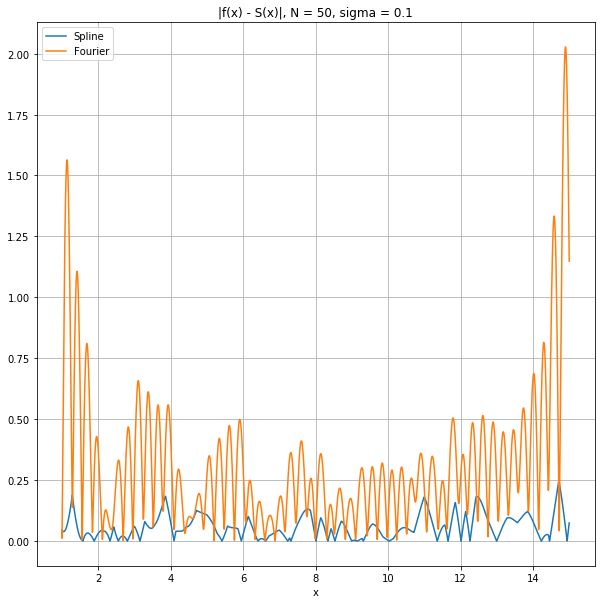

In [16]:
mkerrplot(50, 0.1, True)

Многочлен Ньютона даёт очень большую ошибку на границах отрезка, особенно при большом количестве точек (что не удивительно, т.к. это многочлен высокой степени с какими-то некрасивыми коэфициентами), а при маленьком количестве точек получается недостаточно точное приближение на всём отрезке. При этом шум влияет на него примерно так же, как и на сплайны. Сплайны хорошо приближают функцию даже при большом количестве точек (т.к. это много склеенных многочленов третьей степени). Интерполяция через преобразование фурье плохо подходит для этого случая, при маленьком количестве точек получается плохая точность, а при большом тоже плохая из-за лишних колебаний.


## Оценка констант Лебега

Константа Лебега -- это число, определяющее усточивость интерполяции по отношению к шумам в значениях функции $f(x)$; оно определяется как
$$
L := \sup_{t \in [a,b]} \sum_{j=0}^{K-1} \vert \phi_j(t) \vert,
$$
где $\phi_j$ -- базис интерполяции, зависящий как от метода (тригонометрический/многочлены/сплайны), так и от сетки (коэффициенты интерполяции, очевидно, зависят от неё).

Если не оговорено иного, то рассматривается равномерная сетка на $[-1,1]$. Для интерполяционного многочлена и тригонометрической интерполяции можно получить аналитически оценки на константу Лебега.

### Задание 2 (15 баллов)

Докажите, что если $N \geq 2$, то константа Лебега для интерполяционного многочлена ограничена снизу как 
$$
L_N \geq K \frac{2^N}{N^{3/2}}
$$
с константой $K$, не зависящей от $N$.

### Задание 3 (15 баллов)

Докажите, что если $N \geq 2$, то константа Лебега для интерполяционного многочлена ограничена сверху как $L_N \leq K_0 2^N$ с константой $K_0$, не зависящей от $N$.

Подсказка к 2 и 3: докажите и используйте
$$
\prod_{j=0, ~j \neq i}^{n-1} \vert i-j\vert = i!(n-1-i)!
$$
и
$$
\prod_{j=0}^{n-1} (j+1/2) \geq \frac{(n-1)!}{2 \sqrt{n-1}}
$$
для $n \geq 2$.

$$
\prod_{j=0, ~j \neq i}^{n} \vert i-j\vert = \left(\prod_{j=0}^{i-1} (i-j) \right) \left( \prod_{j=i+1}^{n} (j-i) \right)= i!\left( \prod_{k=1}^{n-i} (k+i-i) \right) = i!(n-i)!
$$

Вторая подсказка легко доказывается с помощью индукции, но использовать её не получилось =(

$$
x_i = \frac{2i}{n} - 1
$$

$$
\vert\phi_i(x)\vert = \left\vert\prod_{j=0, ~j \neq i}^{n}\frac{x - x_j}{x_i - x_j}\right\vert = \frac{\prod_{j=0, ~j \neq i}^{n} \vert x - x_j\vert}{\prod_{j=0, ~j \neq i}^{n} \vert x_i - x_j\vert} = \frac{n^n\prod_{j=0, ~j \neq i}^{n} \vert x - x_j\vert}{2^ni!(n-i)!}
$$

Представим $x$ как $x_k + \delta, ~ \vert\delta\vert < \frac{1}{n}$, т.е. $x_k$ - ближайшая к $x$ точка в сетке:

$$
\prod_{j=0, ~j \neq i}^{n} \vert x - x_j\vert = \prod_{j=0, ~j \neq i}^{n} \left\vert \frac{2k}{n} - 1 + \delta - \frac{2j}{n} + 1\right\vert = \frac{2^n}{n^n}\prod_{j=0, ~j \neq i}^{n} \left\vert k - j + \frac{n\delta}{2} \right\vert < K\frac{2^n}{n^n}n!
$$

$$
\vert\phi_i(x)\vert < K\frac{n^n}{2^ni!(n-i)!}\frac{2^n}{n^n}n! = K\frac{n!}{i!(n-i)!}
$$

$$
\sum_{i=0}^{n} \vert \phi_i(x) \vert < \sum_{i=0}^{n}K\frac{n!}{i!(n-i)!} = Kn!\sum_{i=0}^{n}\frac{1}{i!(n-i)!} = Kn!\frac{2^n}{n!} = K2^n
$$



### Задание 4 (5 баллов)

Докажите, что константа Лебега для тригонометрической инетрполяции ограничена сверху как $L_N \leq K N$, где $K$ не зависит от $N$.

#### ВАШЕ РЕШЕНИЕ ЗДЕСЬ

Оценим константы Лебега для многочлена Ньютиона, тригонометрической интерполяции и сплайна эмпирически для равномерной сетки и Чебышёвской сетки (построенной из корней многочлена Чебышёва). Пусть нас интересует отрезок $[0,1]$ и на нём берётся $N$ узлов для интерполяции. Можете приблизительно вычислять максимум в выражении для константы Лебега как удобно, не забудьте выписать, что является базисными функциями для каждого из методов.

### Задание 5 (15 баллов)

Нарисуйте зависимость $L_N$ от $N$ для трёх алгоритмов интерполяции (рассмотрите $N \in [5,1000]$ ) для равномерной и чебышёвской сеток. Опишите увиденный результат, сравните его с теоретическими оценками. Если графики нечитаемы, попробуйте их нарисовать в логарифмических осях.

In [0]:
def fTest(x):
    #maps R -> R
    #input x [batch]
    #output [batch]
    
    return np.exp(-0.1*x) + 1/x * np.sin(1*np.pi * x)+ np.exp(0.07*x)

In [0]:
# YOUR PLOTS HERE